# COMS-E6998-010: Homework 4 {-}
__Name:__ Nicholas Christman (n2677)   
__Due:__  Nov. 22, 2002


In [1]:
from __future__ import print_function, division

import sys
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# set global seed
seed = 6998
torch.manual_seed(seed)

In [2]:
# use a GPU if there is one available
cuda_availability = torch.cuda.is_available()
if cuda_availability:
    device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
else:
    device = 'cpu'
print('\n*************************')
print('GPU Available: {}'.format(cuda_availability))
print('Current Device: {}'.format(device))
print('*************************\n')
# display the GPU info
if cuda_availability:
    !nvidia-smi


*************************
GPU Available: False
Current Device: cpu
*************************



***
# Problem 1 - Transfer learning: Shallow learning vs Finetuning, Pytorch (30) {-}

Two major transfer learning scenarios are as follows:   
* Finetuning the base model: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on Imagenet dataset. Rest of the training looks as usual however the learning rate schedule for transfer learning may be different.
* Base model as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.  

_References:_   
[1] Pytorch blog. Transfer Learning for Computer Vision Tutorial by S. Chilamkurthy   
&emsp; Available at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html   
[2] Notes on Transfer Learning. CS231n Convolutional Neural Networks for Visual Recognition.   
&emsp; Available at https://cs231n.github.io/transfer-learning/   
[3] Visual Domain Decathlon (https://www.robots.ox.ac.uk/~vgg/decathlon/)   

In [4]:
# used one time to extract dataset
# # to extract tar
# import tarfile
# tar = tarfile.open("data/ucf101.tar", 'r')
# tar.extractall()
# tar.close()

In [98]:
###### Functions for Problem 1 ######

# function taken from the Pytorch tutorial [2]
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def train_model(model, criterion, optimizer, scheduler, 
                num_epochs=25, gpu_check=False, 
                start_epoch=0, save_epochs=0, 
                save_dir='', history={}, verbose=0):
    since = time.time()
    
    print('Training model...')
    print('=' * 20)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # if we aren't loading a model, start a new history dict
    if not history:
        history = {'train': {
                            'epoch': [],
                            'time': [],
                            'lr': [],
                            'loss': [],
                            'acc': [],
                            'best_acc': 0.0
                        }, 
                   'val': {
                           'epoch': [],
                           'time': [],
                           'lr': [],
                           'loss': [],
                           'acc': [],
                           'best_acc': 0.0
                       }
                  }

    for epoch in range(start_epoch, num_epochs):
        
        print('Epoch {}/{} (lr = {:.3e})'.format(epoch+1, num_epochs,
                                             optimizer.param_groups[0]['lr']))
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            phase_start = time.time()

            # use temp variable for brevity 
            epoch_hist = history[phase]

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            num_iters = len(dataloaders[phase])
            iter_time = 0
            for iters, (inputs, labels) in enumerate(dataloaders[phase]):
                iter_start = time.time()
                # move data to "device" (i.e., GPU)
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                iter_time += (time.time() - iter_start)
                if (iters % 10 == 0 or iters == num_iters) or verbose == 1:
                    loss_data = loss.item() 
                    print('\r{} [{}/{} ({:.0f}%)]   Time: {:.4f}   Loss: {:.4f}'.
                            format(phase_str[phase], 
                                   iters * len(inputs), 
                                   len(dataloaders[phase].dataset),
                                   100. * iters / len(dataloaders[phase]), 
                                   iter_time, loss_data), end='')
            # store some stats
            epoch_time = time.time() - phase_start

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('\r{} [Done!]   Time: {:.4f}   Loss: {:.4f}   Acc: {:.4f}'.
                   format(phase_str[phase], epoch_time, 
                         epoch_loss, epoch_acc, end=''))

            # store the best accuracy and deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


            # store the history
            epoch_hist['epoch'].append(epoch) # added in case loading history
            epoch_hist['time'].append(epoch_time)
            epoch_hist['lr'].append(optimizer.param_groups[0]['lr'])
            epoch_hist['loss'].append(epoch_loss)
            epoch_hist['acc'].append(epoch_acc.data.cpu().numpy().item())
            epoch_hist['best_acc'] = np.max(epoch_hist['acc'])


        # for debug, check gpu performance
        if gpu_check:
            return model, history
        
        if (epoch > 0 and epoch != num_epochs-1) and \
            ((epoch+1) % save_epochs == 0 and save_dir):
            checkpoint=os.path.join(save_dir, 
                                    'E{}_checkpoint.th'.format(epoch+1))
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
            }, filename=checkpoint)
            # dump the data for later
            json_file = os.path.join(save_dir,
                                     'E{}_history.json'.format(epoch+1))
            with open(json_file, 'w') as fp:
                json.dump(history, fp)
                
            print(' + Saved checkpoint \'{}\''.format(checkpoint))
        
        # console output        
        print('-' * 20)
    if save_dir:
        checkpoint= os.path.join(save_dir, 'final_model.th')
        # save the model
        save_checkpoint({
            'state_dict': model.state_dict(),
            'best_acc': best_acc,
        }, filename=checkpoint)
        # dump the data for later
        with open(os.path.join(save_dir,'final_history.json'), 'w') as fp:
            json.dump(history, fp)
        print(' + Saved checkpoint \'{}\''.format(checkpoint))
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        

def load_checkpoint(model,model_dir,start_epoch):
    # if model exists, then try to load it
    path = os.path.join(model_dir,'E{}_checkpoint.th'.format(start_epoch))
    if os.path.isfile(path):
         # resume from checkpoint if Colab booted us during training
        print("=> Loading checkpoint '{}'".format(path))
        checkpoint = torch.load(path)
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Loaded checkpoint (epoch {})" .format(checkpoint['epoch']))
    else:
        print("=> No checkpoint found at '{}'".format(path))
        sys.exit()
    # load history structure
    history_file = os.path.join(model_dir,'E{}_history.json'.format(start_epoch))
    if os.path.isfile(history_file):
        with open(history_file) as json_file:
            history = json.load(json_file) 
    else:
        print('History file \'{}\' does not exist.'.format(checkpoint))
   
    return model,history


def save_checkpoint(state, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)
    
###### Global Vars for Problem 1 ######
phase_str = {'train': 'Training', 'val': 'Validating'}

### 1.1(a) Data exploration  {-}

In [139]:
# hyperparameters
batch_size = 64
num_epochs = 200
momentum = 0.9
lr_init = 0.001
lr_decay = 0.1
lr_epochs = [np.floor(0.3*num_epochs),
              np.floor(0.6*num_epochs),
              np.floor(0.9*num_epochs)]


train_phases = ['train', 'val']

# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # ImageNet is 224x224x3, so we need to stay the same
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224), # ImageNet is 224x224x3, so we need to stay the same
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data/dtd'
data_name = 'ucf101'
data_dir = os.path.join('data',data_name)

# the training & validation data
image_datasets = {}
dataloaders = {}
dataset_sizes = {}
for x in train_phases:
    image_datasets[x] = datasets.ImageFolder(os.path.join(data_dir, x), 
                                             data_transforms[x])

    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], 
                                                 batch_size=batch_size,
                                                 shuffle=True, 
                                                 num_workers=4)
    
    dataset_sizes[x] = len(image_datasets[x])

# get some data info
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print('Number of classes: {}'.format(num_classes))
for x in ['train', 'val']:
    print('Dataset \'{}\' size: {}'.format(x,dataset_sizes[x]))


# read in the annotations and get the actual class names
# ann_dir = 'data/dtd_ann'
ann_dir = os.path.join('data',data_name+'_ann')

# with open(os.path.join(ann_dir,'dtd_train.json')) as f:
with open(os.path.join(ann_dir,'ucf101_train.json')) as f:
    train_ann = json.load(f)
# extract the "class_names" (last 4 digits of category id) and actual names (class labels)
real_names = dict([ (str(cat['id'])[-4:], cat['name']) for cat in train_ann['categories'] ])
    
# Count the number of images per class
from collections import Counter
tmp = dict(Counter(image_datasets['train'].targets))
# for displaying, let's replace the class # with the actual class name
for k, v in real_names.items():
    tmp[v] = tmp[int(k)-1]
    del tmp[int(k)-1]
print('Number of images per class:')
min_vals = min(tmp.values())
# min_classes = [key for key in tmp if tmp[key] == min_vals] 
print('  > Minimum count of {}'.format(min_vals))
max_vals = max(tmp.values())
# max_classes = [key for key in tmp if tmp[key] == max_vals] 
print('  > Maximum count of {}'.format(max_vals))
avg_vals = np.mean(list(tmp.values()))
print('  > Mean count of {:0.3f}'.format(avg_vals))


Number of classes: 101
Dataset 'train' size: 7585
Dataset 'val' size: 1952
Number of images per class:
  > Minimum count of 57
  > Maximum count of 96
  > Mean count of 75.099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


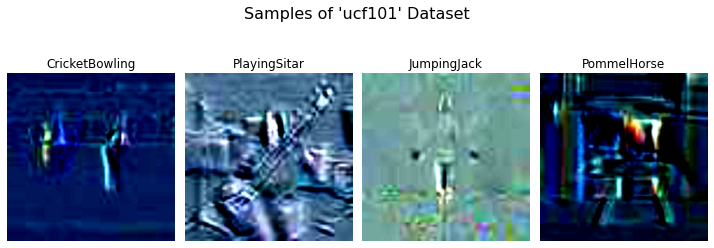

In [191]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))
# select 4 unique classes to demo
uni, ind = np.unique(classes, return_index=True)
use = np.random.choice(ind, 4, replace=False)
# display samles
title = 'Samples of \'{}\' Dataset'.format(data_name)
fig = plt.figure(figsize=(10,4))
fig.suptitle(title, fontsize=16)
for i,u in enumerate(use):
    axn = fig.add_subplot(1, 4, i+1)
    axn.set_title(real_names[class_names[classes[u]]])
    axn.axis('off')
    axn.imshow(inputs[u].permute(1, 2, 0))     
plt.tight_layout(pad=1.0)
plt.show()

__Dataset Explanation:__  

For this problem I chose to use the [UCF101 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF101.php "ucf101 dataset"). According the the referenced website, the UCF101 dataset consists of "realistic action videos, collected from YouTube, having 101 action categories." As the descrption states, the UCF101 dataset has 101 classes representing different actions (e.g., longjump, headmassage, fencing, etc.). The data is split into training, validation, and test sets consiting of 7629, 1908, and 3783 images, respectively. As displayed above, the number of images per class varies: there is a minimum of 57 images per class, a maximum of 96 images per class, and a mean of 75.099 images per class. Also displayed above are 4 sample images from the dataset.   

*Note: The Visual Domain Decathlon dataset abstracted away the actual class names, so 4 extra lines of code (above) were implemened to grab the actual class names out of the annotations file.*

### 1.1(b) Finetuning source model  {-}
Below we will load a pretrained Resnet50 model (using Pytorch)

In [ ]:
prob_name = 'prob1b'
save_epochs = 10
history = {}

# prepare the pre-trained model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# change the output layer to match number of new classes
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# for checkpoints (save/load dir)
start_epoch = 0
save_dir = os.path.join('checkpoints',prob_name)
if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
# model_ft, history = load_checkpoint(model_ft, save_dir, start_epoch) # uncomment to load model

# move model to the GPU
model_ft = model_ft.to(device)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=momentum)

# Decay learning rate per hyperparameters above
lr_scheduler_ft = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft,
                                                      milestones=lr_epochs, 
                                                      gamma=lr_decay)#,
lr_scheduler_ft.last_epoch = start_epoch - 1

model_ft, history = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft,
                                num_epochs=num_epochs, start_epoch=start_epoch, 
                                save_epochs=save_epochs, save_dir=save_dir, 
                                history=history, verbose=1)

_Note: the following snippet was copied from the actual console output that included all 200 epochs. Here the output is shortened for brevity, but still illustrates the learning rate decay as well as shows the first and last epoch._
```
Training model...
====================
Epoch 1/200 (lr = 1.000e-03)
Training [Done!]   Time: 76.9906   Loss: 4.5549   Acc: 0.0285
Validating [Done!]   Time: 6.2745   Loss: 4.3802   Acc: 0.0599
--------------------
...
--------------------
Epoch 62/200 (lr = 1.000e-04)
Training [Done!]   Time: 76.8071   Loss: 0.5700   Acc: 0.8596
Validating [Done!]   Time: 6.3591   Loss: 1.1651   Acc: 0.6844
--------------------
...
--------------------
Epoch 122/200 (lr = 1.000e-05)
Training [Done!]   Time: 76.5515   Loss: 0.4447   Acc: 0.8932
Validating [Done!]   Time: 6.3091   Loss: 1.1292   Acc: 0.6952
--------------------
...
--------------------
Epoch 182/200 (lr = 1.000e-06)
Training [Done!]   Time: 76.2601   Loss: 0.4077   Acc: 0.8985
Validating [Done!]   Time: 6.2904   Loss: 1.1320   Acc: 0.6926
--------------------
...
--------------------
Epoch 200/200 (lr = 1.000e-06)
Training [Done!]   Time: 76.6068   Loss: 0.4183   Acc: 0.8976
Validating [Done!]   Time: 6.3098   Loss: 1.1273   Acc: 0.6993
--------------------
 + Saved checkpoint 'checkpoints/prob1b/final_model.th'
Training complete in 276m 39s
Best val Acc: 0.705943
```

### 1.1(c) Finetuning source model (cont.)  {-}
_Per Piazza @283, we will have different initial LRs but will still decay at the same rate._

In [ ]:
prob_name = 'prob1c_1'
save_epochs = 10
history = {}

##### PART 1: LR = 0.01
# for this part, we set initial training rate to 0.01
# but will use the same decay schedule
lr_init = 0.01

# prepare the pre-trained model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# change the output layer to match number of new classes
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# for checkpoints (save/load dir)
start_epoch = 0
save_dir = os.path.join('checkpoints',prob_name)
if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
# model_ft, history = load_checkpoint(model_ft, save_dir, start_epoch) # uncomment to load model

# move model to the GPU
model_ft = model_ft.to(device)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=momentum)

# Decay learning rate per hyperparameters above
lr_scheduler_ft = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft,
                                                      milestones=lr_epochs, 
                                                      gamma=lr_decay)#,
lr_scheduler_ft.last_epoch = start_epoch - 1

model_ft, history = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft,
                                num_epochs=num_epochs, start_epoch=start_epoch, 
                                save_epochs=save_epochs, save_dir=save_dir, 
                                history=history, verbose=1)

_Note: the following snippet was copied from the actual console output that included all 200 epochs. Here the output is shortened for brevity, but still illustrates the learning rate decay as well as shows the first and last epoch._
```
Training model...
====================
Epoch 1/200 (lr = 1.000e-02)
Training [Done!]   Time: 76.6766   Loss: 3.9958   Acc: 0.0961
Validating [Done!]   Time: 6.2765   Loss: 3.3706   Acc: 0.1870
--------------------
...
--------------------
Epoch 62/200 (lr = 1.000e-03)
Training [Done!]   Time: 76.4734   Loss: 0.3926   Acc: 0.8958
Validating [Done!]   Time: 6.2775   Loss: 1.0978   Acc: 0.7444
--------------------
...
--------------------
Epoch 122/200 (lr = 1.000e-04)
Training [Done!]   Time: 76.4053   Loss: 0.2316   Acc: 0.9382
Validating [Done!]   Time: 6.2646   Loss: 0.9392   Acc: 0.7664
--------------------
...
--------------------
Epoch 182/200 (lr = 1.000e-05)
Training [Done!]   Time: 76.5361   Loss: 0.2006   Acc: 0.9471
Validating [Done!]   Time: 6.2644   Loss: 0.9308   Acc: 0.7654
--------------------
...
--------------------
Epoch 200/200 (lr = 1.000e-05)
Training [Done!]   Time: 76.5081   Loss: 0.2131   Acc: 0.9432
Validating [Done!]   Time: 6.2791   Loss: 0.9273   Acc: 0.7720
--------------------
 + Saved checkpoint 'checkpoints/prob1c_1/final_model.th'
Training complete in 275m 38s
Best val Acc: 0.778176
```

In [ ]:
prob_name = 'prob1c_2'
save_epochs = 10
history = {}

##### PART 2: LR = 0.1
# for this part, we set initial training rate to 0.1
# but will use the same decay schedule
lr_init = 0.1

# prepare the pre-trained model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# change the output layer to match number of new classes
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# for checkpoints (save/load dir)
start_epoch = 0
save_dir = os.path.join('checkpoints',prob_name)
if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
# model_ft, history = load_checkpoint(model_ft, save_dir, start_epoch) # uncomment to load model

# move model to the GPU
model_ft = model_ft.to(device)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=momentum)

# Decay learning rate per hyperparameters above
lr_scheduler_ft = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft,
                                                      milestones=lr_epochs, 
                                                      gamma=lr_decay)#,
lr_scheduler_ft.last_epoch = start_epoch - 1

model_ft, history = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft,
                                num_epochs=num_epochs, start_epoch=start_epoch, 
                                save_epochs=save_epochs, save_dir=save_dir, 
                                history=history, verbose=1)

_Note: the following snippet was copied from the actual console output that included all 200 epochs. Here the output is shortened for brevity, but still illustrates the learning rate decay as well as shows the first and last epoch._
```
Training model...
====================
Epoch 1/200 (lr = 1.000e-01)
Training [Done!]   Time: 74.2095   Loss: 4.7203   Acc: 0.0161
Validating [Done!]   Time: 6.1948   Loss: 4.4782   Acc: 0.0179
--------------------
...
--------------------
Epoch 62/200 (lr = 1.000e-02)
Training [Done!]   Time: 75.8188   Loss: 0.9828   Acc: 0.7429
Validating [Done!]   Time: 6.2297   Loss: 1.4431   Acc: 0.6429
--------------------
...
--------------------
Epoch 122/200 (lr = 1.000e-03)
Training [Done!]   Time: 75.7174   Loss: 0.4788   Acc: 0.8736
Validating [Done!]   Time: 6.2252   Loss: 1.5849   Acc: 0.6583
--------------------
...
--------------------
Epoch 182/200 (lr = 1.000e-04)
Training [Done!]   Time: 75.8663   Loss: 0.4285   Acc: 0.8885
Validating [Done!]   Time: 6.2276   Loss: 1.5831   Acc: 0.6701
--------------------
...
--------------------
Epoch 200/200 (lr = 1.000e-04)
Training [Done!]   Time: 75.8688   Loss: 0.4234   Acc: 0.8856
Validating [Done!]   Time: 6.2689   Loss: 1.5631   Acc: 0.6706
--------------------
 + Saved checkpoint 'checkpoints/prob1c_2/final_model.th'
Training complete in 273m 19s
Best val Acc: 0.677254
```

Loaded data from JSON file. (file:checkpoints/prob1b/final_history.json)

Loaded data from JSON file. (file:checkpoints/prob1c_1/final_history.json)

Loaded data from JSON file. (file:checkpoints/prob1c_2/final_history.json)



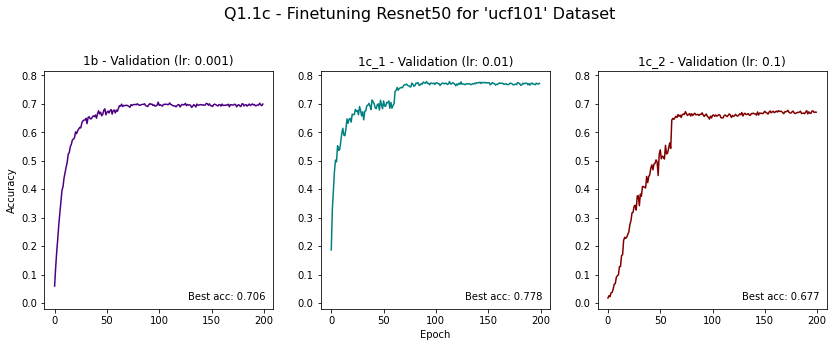

In [97]:
data_name = 'ucf101'
prob_names = ['prob1b','prob1c_1','prob1c_2']
history = {'prob1b':{},'prob1c_1':{},'prob1c_2':{}}
for prob_name in history.keys():
    # load the stored json data into dictionary if it doesn't exist
    hist_file = 'checkpoints/{}/final_history.json'.format(prob_name)
    if os.path.isfile(hist_file):
        with open(hist_file) as json_file:
            history[prob_name] = json.load(json_file)
            print('Loaded data from JSON file. (file:{})\n'.format(hist_file))
    else:
        sys.exit('File \'{}\' does not exist.'.format(hist_file))

# display the resuls
plt_1b = history['prob1b']['val']
plt_1c1 = history['prob1c_1']['val']
plt_1c2 = history['prob1c_2']['val']

# best acc text
best_1b = 'Best acc: {:0.3f}'.format(plt_1b['best_acc'])
best_1c1 = 'Best acc: {:0.3f}'.format(plt_1c1['best_acc'] )
best_1c2 = 'Best acc: {:0.3f}'.format(plt_1c2['best_acc'] )

# define figure
title = 'Q1.1c - Finetuning Resnet50 for \'{}\' Dataset'.format(data_name)
fig = plt.figure(figsize=(12,5))
fig.suptitle(title, fontsize=16)
##
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('1b - Validation (lr: 0.001)')
ax1.set_ylabel('Accuracy')
ax1.plot(plt_1b['epoch'], plt_1b['acc'], color='indigo')
ax1.text(0.63, 0.07, best_1b, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top')
##
ax2 = fig.add_subplot(1, 3, 2,sharey = ax1)
ax2.set_title('1c_1 - Validation (lr: 0.01)')
ax2.set_xlabel('Epoch')
ax2.plot(plt_1c1['epoch'], plt_1c1['acc'], color='teal')
ax2.text(0.63, 0.07, best_1c1, transform=ax2.transAxes, fontsize=10,
        verticalalignment='top')
##
ax3 = fig.add_subplot(1, 3, 3,sharey = ax1)
ax3.set_title('1c_2 - Validation (lr: 0.1)')
ax3.plot(plt_1c2['epoch'], plt_1c2['acc'], color='maroon')
ax3.text(0.63, 0.07, best_1c2, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top')

##
# configure ticks/labels/layout
plt.tight_layout(pad=2.0)
plt.show()

__Answer:__ All three accuracy curves are somewhat similar at first; however, couple key differences do standout. First, the most aggressive learning rate appears to perform the worst (even from the beginning) -- this is likely because the more aggressive the learning rate, the faster the model looses the information from the pretrained model. Second, the curves with a more agressive initial learning rates of 0.01 and 0.1 have a noticeable jump in accuracy shortly after epoch 50. This jump is mostly likely at epoch 60, where the first learning rate adjustment occurs. Overall, the learning rate schedule in the middle (both visually above and numerically) appears to produce the best accuracy of ~78%. This configuraiton, initial learning rate of 0.01, appears to retain just enough information from the pretrained model to establish the best model for the ucf101 dataset.

***
### 1.2(a) Feature extractor {-}

In [ ]:
save_epochs = 10
##### Q2, Feature Extraction: LR = 1.0, 0.1, 0.01, 0.001
# we will use the same decay schedule as before
lr_inits = [1.0, 0.1, 0.01, 0.001]
for lr_init in lr_inits:
    history = {}
    # directory name
    lr_str = str(lr_init).replace('.','_')
    prob_name = 'prob2a-{}'.format(lr_str)
    # prepare the pre-trained model
    model_ft = models.resnet50(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False

    num_ftrs = model_ft.fc.in_features
    # change the output layer to match number of new classes
    # new layers have 'requires_grad' set True by default
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    # for checkpoints (save/load dir)
    start_epoch = 0
    save_dir = os.path.join('checkpoints',prob_name)
    if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
    # model_ft, history = load_checkpoint(model_ft, save_dir, start_epoch) # uncomment to load model

    # move model to the GPU
    model_ft = model_ft.to(device)
    cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    # add '.fc' to optimize only last, fully connected layers
    optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr_init, momentum=momentum)

    # Decay learning rate per hyperparameters above
    lr_scheduler_ft = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft,
                                                          milestones=lr_epochs, 
                                                          gamma=lr_decay)#,
    lr_scheduler_ft.last_epoch = start_epoch - 1

    model_ft, history = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft,
                                    num_epochs=num_epochs, start_epoch=start_epoch, 
                                    save_epochs=save_epochs, save_dir=save_dir, 
                                    history=history, verbose=1)

    print('====================')
    print()



_Note: the following snippet was copied from the actual console output that included all 200 epochs. Here the output is shortened for brevity, but still illustrates the learning rate decay as well as shows the first and last epoch._

#### Learning Rate: 1.0
```
Training model...
====================
Epoch 1/200 (lr = 1.000e+00)
Training [Done!]   Time: 25.3511   Loss: 398.0668   Acc: 0.0401
Validating [Done!]   Time: 6.6930   Loss: 151.6984   Acc: 0.0866
--------------------
...
--------------------
Epoch 62/200 (lr = 1.000e-01)
Training [Done!]   Time: 25.5867   Loss: 33.7680   Acc: 0.3655
Validating [Done!]   Time: 6.5618   Loss: 39.2671   Acc: 0.3053
--------------------
...
--------------------
Epoch 122/200 (lr = 1.000e-02)
Training [Done!]   Time: 25.6513   Loss: 12.5549   Acc: 0.4767
Validating [Done!]   Time: 6.5984   Loss: 20.8495   Acc: 0.3253
--------------------
...
--------------------
Epoch 182/200 (lr = 1.000e-03)
Training [Done!]   Time: 25.6565   Loss: 11.3373   Acc: 0.5022
Validating [Done!]   Time: 6.5700   Loss: 19.8529   Acc: 0.3330
--------------------
...
--------------------
Epoch 200/200 (lr = 1.000e-03)
Training [Done!]   Time: 25.6677   Loss: 11.4089   Acc: 0.4891
Validating [Done!]   Time: 6.5546   Loss: 19.8088   Acc: 0.3284
--------------------
 + Saved checkpoint 'checkpoints/prob2a-1_0/final_model.th'
Training complete in 107m 22s
Best val Acc: 0.336066
====================
```

#### Learning Rate: 0.1
```
Training model...
====================
Epoch 1/200 (lr = 1.000e-01)
Training [Done!]   Time: 25.6384   Loss: 7.1904   Acc: 0.0647
Validating [Done!]   Time: 6.5518   Loss: 6.4004   Acc: 0.1071
--------------------
...
--------------------
Epoch 62/200 (lr = 1.000e-02)
Training [Done!]   Time: 25.6582   Loss: 3.3943   Acc: 0.3887
Validating [Done!]   Time: 6.5794   Loss: 3.9992   Acc: 0.2966
--------------------
...
--------------------
Epoch 122/200 (lr = 1.000e-03)
Training [Done!]   Time: 25.5503   Loss: 1.9840   Acc: 0.5055
Validating [Done!]   Time: 6.5116   Loss: 2.9231   Acc: 0.3478
--------------------
...
--------------------
Epoch 182/200 (lr = 1.000e-04)
Training [Done!]   Time: 25.6189   Loss: 1.9690   Acc: 0.5073
Validating [Done!]   Time: 6.5537   Loss: 2.8825   Acc: 0.3530
--------------------
...
--------------------
Epoch 200/200 (lr = 1.000e-04)
Training [Done!]   Time: 25.5857   Loss: 1.9637   Acc: 0.5069
Validating [Done!]   Time: 6.4941   Loss: 2.8790   Acc: 0.3530
--------------------
 + Saved checkpoint 'checkpoints/prob2a-0_1/final_model.th'
Training complete in 107m 17s
Best val Acc: 0.358607
====================
```

#### Learning Rate: 0.01
```
Training model...
====================
Epoch 1/200 (lr = 1.000e-02)
Training [Done!]   Time: 25.5508   Loss: 4.4091   Acc: 0.0518
Validating [Done!]   Time: 6.5499   Loss: 3.9907   Acc: 0.1189
--------------------
...
--------------------
Epoch 62/200 (lr = 1.000e-03)
Training [Done!]   Time: 25.6229   Loss: 2.5265   Acc: 0.3673
Validating [Done!]   Time: 6.5157   Loss: 2.7380   Acc: 0.3171
--------------------
...
--------------------
Epoch 122/200 (lr = 1.000e-04)
Training [Done!]   Time: 25.6295   Loss: 2.4592   Acc: 0.3860
Validating [Done!]   Time: 6.5544   Loss: 2.7141   Acc: 0.3248
--------------------
...
--------------------
Epoch 182/200 (lr = 1.000e-05)
Training [Done!]   Time: 25.6305   Loss: 2.4323   Acc: 0.3815
Validating [Done!]   Time: 6.5436   Loss: 2.7005   Acc: 0.3253
--------------------
...
--------------------
Epoch 200/200 (lr = 1.000e-05)
Training [Done!]   Time: 25.5990   Loss: 2.4401   Acc: 0.3852
Validating [Done!]   Time: 6.5545   Loss: 2.7010   Acc: 0.3268
--------------------
 + Saved checkpoint 'checkpoints/prob2a-0_01/final_model.th'
Training complete in 107m 15s
Best val Acc: 0.330943
====================
```

#### Learning Rate: 0.001
```
Training model...
====================
Epoch 1/200 (lr = 1.000e-03)
Training [Done!]   Time: 25.6115   Loss: 4.5942   Acc: 0.0183
Validating [Done!]   Time: 6.5671   Loss: 4.4985   Acc: 0.0451
--------------------
...
--------------------
Epoch 62/200 (lr = 1.000e-04)
Training [Done!]   Time: 25.6556   Loss: 3.0775   Acc: 0.2746
Validating [Done!]   Time: 6.5648   Loss: 3.0905   Acc: 0.2664
--------------------
...
--------------------
Epoch 122/200 (lr = 1.000e-05)
Training [Done!]   Time: 25.4986   Loss: 3.0250   Acc: 0.2882
Validating [Done!]   Time: 6.5181   Loss: 3.0606   Acc: 0.2700
--------------------
...
--------------------
Epoch 182/200 (lr = 1.000e-06)
Training [Done!]   Time: 25.6467   Loss: 3.0256   Acc: 0.2854
Validating [Done!]   Time: 6.5078   Loss: 3.0647   Acc: 0.2613
--------------------
...
--------------------
Epoch 200/200 (lr = 1.000e-06)
Training [Done!]   Time: 25.6468   Loss: 3.0375   Acc: 0.2786
Validating [Done!]   Time: 6.5521   Loss: 3.0639   Acc: 0.2664
--------------------
 + Saved checkpoint 'checkpoints/prob2a-0_001/final_model.th'
Training complete in 107m 15s
Best val Acc: 0.272029
====================
```

Loaded data from JSON file. (file:checkpoints/prob2a-1_0/final_history.json)

Loaded data from JSON file. (file:checkpoints/prob2a-0_1/final_history.json)

Loaded data from JSON file. (file:checkpoints/prob2a-0_01/final_history.json)

Loaded data from JSON file. (file:checkpoints/prob2a-0_001/final_history.json)



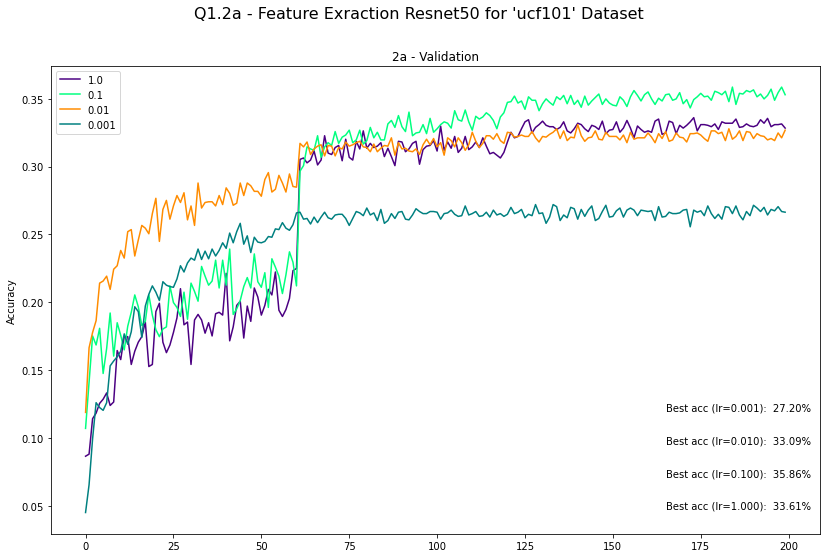

In [142]:
data_name = 'ucf101'

 # define figure
title = 'Q1.2a - Feature Exraction Resnet50 for \'{}\' Dataset'.format(data_name)
fig = plt.figure(figsize=(12,8))
fig.suptitle(title, fontsize=16)
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title('2a - Validation')
ax1.set_ylabel('Accuracy')
txt_y = 0 # for best acc placement
plt_style = ['indigo','springgreen','darkorange','teal']
# plot each curve
for i,lr_init in enumerate(lr_inits):
    # directory name
    lr_str = str(lr_init).replace('.','_')
    prob_name = 'prob2a-{}'.format(lr_str)
    
    # load the stored json data into dictionary if it doesn't exist
    hist_file = 'checkpoints/{}/final_history.json'.format(prob_name)
    if os.path.isfile(hist_file):
        with open(hist_file) as json_file:
            #history[prob_name] = json.load(json_file)
            history = json.load(json_file)
            print('Loaded data from JSON file. (file:{})\n'.format(hist_file))
    else:
        sys.exit('File \'{}\' does not exist.'.format(hist_file))
    
    # handle to validation data
    plt_2a = history['val']
    # best acc text
    best_2a = 'Best acc (lr={:0.3f}):  {:0.2f}%'.format(lr_init,100*plt_2a['best_acc'])
    txt_y += 0.07
    # display the results
    ax1.plot(plt_2a['epoch'], plt_2a['acc'],color=plt_style[i],label=str(lr_init))
    ax1.text(0.8, txt_y, best_2a, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top')

ax1.legend()
plt.tight_layout(pad=2.0)
plt.show()

__Answer:__ From the accuracy plots above, it apppears that the initial learning rate of $0.1$ provides the best accuracy after 200 epochs.

### 1.2(b)  Feature extractor (cont.)  {-}
From both transfer learning approaches, which approach and learning rate provides the best results?

__Answer:__ It is quite clear from the experiments above that the __finetuning__ approach provides the superior results in regards to accuracy. Moreover, the finetuning method with initial learning rate of $0.01$ provides the best model, resulting in a validation accuracy of about $78\%$ after $200$ epochs. On the other hand, the feature extraction method trains the network in about $1/3$ of the time (~$30$ sec/epoch vs ~$80$ sec/epoch); unfortunately, I fear that the low accuracy of the feature extraction method on this dataset means that, despite the improved learning time, the feature extraction transfer learning method is not a plausible solution for the hyperparameters and dataset chosen. With that said, it makes sense that the finetuning method is the superior solution given that the target UCF101 dataset is quite different than the source Imagenet dataset (refer to the sample images above) -- among other differences, there is very little edge detail in the UCF101 dataset which means some of hidden layers of the Resnet50 source model will not provide any useful information for the UCF101 target dataset and, as such, should be re-trained (finetuned). Likewise, for the feature extraction method to work well one would expect that the source and target datasets have similar features, which explains why the accuracy is so low in this experiment.

_Note: recall that these results were gathered using the Resnet50 base model pretrained using the Imagenet as the source dataset, applied to the UCF101 target dataset. The hyperparameters chosen for all experiments include a batch size of $64$, the initial learning rates defined above, training length of $200$ epochs, and a learning rate schedule that divides the initial learning rate by $10$ at $30\%$, $60\%$, and $90\%$ of the total epochs. Finally, the SGD loss function was used for all experiments._

***
***
# Problem 2 - Weakly and Semi-Supervised Learning for Image Classification (20) {-}

_References:_   
[1] Yalniz et al. Billion-scale semi-supervised learning for image classification.
Available at https://arxiv.org/pdf/1905.00546.pdf   
[2]  Mahajan et al. Exploring the Limits of Weakly Supervised Pretraining.
Available at https://arxiv.org/pdf/1805.00932.pdf

### 2.1 weakly supervised vs. semi-supervised pretraining {-}
* __What is the difference between weakly supervised and semi-supervised pretraining?__   
   __Answer:__ The primary difference between the two pretraining methods is that weakly supervised pretraining relies on additional data (i.e., noisy labels) that does not exist natively with the data, whereas semi-supervised pretraining does not require such labels.
   
   * _Weakly Supervised Pretraining:_ Weakly supervised pretraining is the process of using 'weak labels' from additional data during supervised learning. For example, [2] uses hashtags from Instagram photos to label their data prior to training the model. These labels are often thought/expected to be somewhat noisy [2]. 
   
   * _Semi-supervised Pretraining:_ Semi-supervised pretraining is the process of using additional unlabeled data to improve supervision. 
   
* **How do they use the same dataset to do two different types of pretraining? _Explain._**   
__Answer:__ The dataset (IG-1B-Targeted) consists of unlabeled images with hashtags (noisy labels). Semi-supervised uses the unlabeled images (for teacher/student model) while weakly supervised uses both the unlabeled images and hashtags. Furthermore, the semi-supervised approach creates three different subsets of images by ranking the images (balanced, unbalanced, and balanced with tags). Both approaches use models that were pre-trained on the ImageNet dataset that are then finetuned for the IG-1B-Targeted dataset. Finally, the semi-supervised approach uses the weakly supervised approach from [2] to train the teacher model in their semi-supervised method (for comparison).   

***
### 2.2(a) {-}
* __Are the models trained using hashtags robust against noise in the labels?__    
__Answer:__ Yes. Per [2], the network architecture chosen for this task leads to underfitting. We know that overfitting causes the network to model the data too well, meaning the noise is modeled in addition to the features of interest; on the contrary, underfitting does not model the noise which creates a more robust model in regards to noisy hashtags.

* **What experiments were done in the paper to study this and what was the finding? _Provide numbers from the paper to support your answer._**   
__Answer:__ The authors used noise injection to study the affects of user supplied (hashtag) labels. The simply replace $p\%$ of the existing hashtags in IG-B1-17k with a hashtag obtained by sampling the marginal distribution of existing hashtags (less the hashtag being replaced). They discovered that the network is "remarkably resilient against label noise." The highlight that a noise level of $p=25\%$ resulted in about $2\%$ reduction in Top-1 accuracy. Moreover, looking at the plots we can see that a noise level twice as large ($p=50\%$) results in approximately 3 times more reduction in Top-1 accuracy (~$6\%$). I think it is safe to assume that the majority of users are good and trustworthy, capable of properly labeling images with applicable hashtags more than $50\%$ of the time. 

### 2.2(b) {-}
* __Why is resampling of hashtag distribution important during pretraining for transfer learning?__   
__Answer:__ According to [2], hashtag resampling is important in order to "obtain good transfer to ImageNet image-classification tasks." This is because it has been studied, and results support, that social media vocabularies (eg., hashtags) follow a certain distribuition (i.e., some say Zipfian is the most common). Because of the distribution, resampling (e.g., uniformly at random) improves bias/variance.  

***
### 2.3(a) {-}
* __Why are there two models, a teacher and a student, and how does the student model leverages the teacher model?__   
__Answer:__ Recall that for semi-supervised learning, unlabeled data is used along with labeled data. Per [1], there are two models (teacher and student) such that one model is creating a new, more reliable dataset from unlabeled data (i.e., the teacher) while the other model is being trained on the new hybrid dataset (i.e., the student). In this system, the teacher model is responsible for removing unreliable image examples from from very large unlabeled datasets ($M >> N$) by first being pretrained on large labeled dataset. Therefore, the student model leverages the teacher model by training it's model on the dataset "curated" by the teacher (i.e., a new labeled dataset that originated from the original unlabeled dataset). 

* __Explain why teacher-student modeling is a type of distillation technique__   
__Answer:__ Per [1], "distillation can be seen as a particular case of self-training, in that the teacher model makes prediction on unlabeled data, and the inferred labels are used to train the student in a supervised fashion." I'm not sure what else needs to be explaine. Distillation is exactly what the authors are performing, except they are applying the technique to image classification, as they state. The teacher is pretrained on a larger, labeled dataset -- the teacher model is then used to sample the unlabeled dataset such that the top-K images are included in the student model training dataset.   

### 2.3(b) {-}
* __What are the parameters K and P in stage 2 of the approach where unlabeled images are assigned classes using teacher network?__   
__Answer:__ $K$ refers to the ordered probabilities of true-positive classifications from the teacher model (e.g., Top-1 reports the single highest probable classifier, Top-2 reports the 2 highest probable classifiers, etc.). $P$ refers the number of classes (or concepts) that each image can represent.     

* **What was the idea behind taking P > 1? _Explain in your own words._**   
__Answer:__ I believe the idea of $P>1$ is that it allows for classes that are not detected/captured very often in smaller unlabeled datasets to have a higher chance of being selected by the teacher model and, thus, included in the students training dataset.   

### 2.3(c) {-}
* __Explain how a new labeled dataset is created using unlabeled images?__   
__Answer:__ As mentioned above, the teacher model is first trained on a pretrained model (i.e., ImageNet) using labeled data. Then, unlabeled data is pushed through the teacher pipeline and labels are assigned based on the parameters ($K$ and $P$) discussed above. The result is a new labeled dataset.   

* **Can an image in this new dataset belong to more than one class ? _Explain._**  
__Answer:__ Yes. If $K>1$ and $P>1$ it is possible that an image could belong to more than one class. Recall that $K$ defines the distribution of probabilities assigned to a specific image (e.g., for $K=P=2$ the teacher might assign an image as $40\%$ tiger and $35\%$ lion). 

### 2.3(d) {-}
_Refer to Figure 5 in the paper._ 
* __Why does the accuracy of the student model first improves as we increase the value of K and then decreases?__   
__Answer:__ Because increasing $K$ beyond $8k$ introduced labeling noise, which causes a drop in accuracy. 

***
***
# Problem 3 - PALEO, FLOPs, Platform Percent of Peak (PPP) (20) {-}
_References:_   
[1] Qi et al. PALEO: A Performance model for Deep Neural Networks. ICLR 2017. Available at https://openreview.net/pdf?id=SyVVJ85lg   
[2] Lu et al. Modeling the Resource Requirements of Convolutional Neural Networks on Mobile Devices. 2017 Available at https://arxiv.org/pdf/1709.09503.pdf

### 3.1 {-}
* __Why achieving peak FLOPs from hardware devices like GPUs is a difficult propostion in real systems?__   
__Answer:__ Becuase it requires specific software libraries ("developed by organizations with intimate knowledge of the underlying hardware"), which is unlikely. Moreover, any process running outside of PALEO could quickly use up computing resources. 

* __How does PPP help in capturing this inefficiency captured in Paleo model?__   
__Answer:__ The platform percent of peak (PPP) tracks the average relative inefficiency instead of trying to trying to capture all of the inefficiency that would require said specialized software libraries. Thus, systems with lower-overheads will have higher PPP (more available resources) while systems with higher overheads will produce a higher PPP.   

### 3.2 {-}
_Lu et al. showed that FLOPs consumed by convolution layers in VG16 account for about 99% of the total FLOPS in the forward pass. We will do a similar analysis for VGG19._ 
* __Calculate FLOPs for different layers in VGG19 and then calculate fraction of the total FLOPs attributed by convolution layers.__   

First, let's examine the difference between VGG-16 and VGG-19 networks (this is known from lecture):

| Layer | VGG16 | VGG19 |
|:-----:|:-----:|:-----:|
|CONV   |13     |16     |
|POOL   |5      |5      |
|ReLU   |15     |18     |
|FC     |3      |3      |
   
Next, let's calculate the FLOPs for VGG19. The functions used are defined and the calculations are made programmatically as shown below.    
_Ref: https://machinethink.net/blog/how-fast-is-my-model/_

* CONV: $K^{2} \cdot C_{in} \cdot H_{out} \cdot W_{out} \cdot C_{out}$
* POOL: $W_{in} \cdot H_{in} \cdot C_{in}$
* ReLU: $W_{out} \cdot H_{out} \cdot C_{out}$
* FC:   $(I-1)\cdot J$   
_Note: the reference says the fully-connected layer FLOPs should be $(2\cdot I - 1)\cdot J$, but I was getting $2x$ when calculating the VGG16 FLOPs, so I think this is a typo in the reference_

In [71]:
from torchvision import models
from torchsummary import summary
from io import StringIO

model_name = 'vgg19'

if model_name == 'vgg19':
    vgg = models.vgg19()
elif model_name == 'vgg16':
    vgg = models.vgg16()
else:
    sys.exit('Unknown model name provided \'{}\''.format(model_name))

# test = vgg.features

# layers = [module for module in vgg.modules() if type(module) != nn.Sequential]


# redirect stdout
# Ref: several stackoverflow posts were reviewed
old_stdout = sys.stdout
new_stdout = StringIO()
sys.stdout = new_stdout
# call torchsummary (this usually prints to output)
summary(vgg, (3, 224, 224))
# capture the stdout 
output = new_stdout.getvalue()
# return stdout
sys.stdout = old_stdout
# using torchsummary to get the model layers + shapes (requires parsing!)
# parse the output of torchsummary print
network = []
for line in output.splitlines()[3:-10]:
    if line.strip().startswith(tuple(modules.keys())):
        tmp = re.split(r'\s{2,}', line)[1:]
        name = tmp[0]
        # string list to real list of ints
        shape = [int(n) for n in (tmp[1])[1:].strip('][').split(', ')[1:]]
        # string int to int
        params = int(tmp[2].replace(',', ''))
        network.append([name,shape,params])
### Now we have the summary of the model network

In [102]:
import re

# functions for calculating FLOPs based on NN layer. 
# Ref: https://machinethink.net/blog/how-fast-is-my-model/
def flopsConv(K,C_in,H_out,W_out,C_out):
#     return 2*H*W*(C_in*(K**2)+1)*C_out
    return (K**2)*C_in*H_out*W_out*C_out

def flopsFC(I,J):
    return (I-1)*J

def flopsPool(J):
    return J

def flopsRelu(J):
    return J
###

# structure for storing results
modules = {'Conv2d': {'count':0,'flops': 0},
           'ReLU': {'count':0,'flops': 0},
           'MaxPool2d': {'count':0,'flops': 0},
           'Linear': {'count':0,'flops': 0}}

print('Claculating FLOPs for {} Network...'.format(model_name))
print('\n')


# print(network)
str = '-'*60
str += '\nLayer  \t\t Shape  \t\t FLOPs\n'
str += '='*60
# calculate the FLOPS for each module
in_shape = [3,224,224]
K = 3
conv_flops = 0
pool_flops = 0
relu_flops = 0
fc_flops = 0
for depth,layer in enumerate(network):
    for module in modules:
        # for first layer, use input channel for calc
        if layer[0].startswith(module):
            tmp = modules[module]
            tmp['count'] += 1
            
            if depth == 0:
                C_in = in_shape[0]
            else:
                C_in = prev_layer[1][0]
            
            # calculate flops based on layer
            if module == 'Conv2d':
                C_out = layer[1][0]
                H_out = layer[1][1]
                W_out = layer[1][2]
                res = flopsConv(K,C_in,H_out,W_out,C_out)
                str += '\n{}     \t{}\t\t{:8.3f}M'.format(module,layer[1],res/1e6)
            # ReLu
            elif module == 'ReLU':
                J = np.prod(layer[1])
                res = flopsRelu(J)
                str += '\n{}     \t{}\t\t{:8.3f}M'.format(module,layer[1],res/1e6)
            # MaxPool
            elif module == 'MaxPool2d':
                J = np.prod(prev_layer[1])
                res =  flopsPool(J)
                str += '\n{}     \t{} \t\t{:8.3f}M'.format(module,layer[1],res/1e6)

            # FC
            elif module == 'Linear':
                I = np.prod(prev_layer[1])
                J = np.prod(layer[1])
                res = flopsFC(I,J)
                str += '\n{}     \t{}   \t\t{:8.3f}M'.format(module,layer[1],res/1e6)
            else:
                str += '\nBad module? \'{}\''.format(module)
            
            
            tmp['flops'] += res 
    # store the previous layer        
    prev_layer = layer

    
# pprint(modules)
str += '\n'
str += '='*60

tot_flops = 0
tot_count = 0
for module in modules:
#     print('{}: {:0.1f}M'.format(res,modules[res]/1e6))
    count = modules[module]['count']
    flops = modules[module]['flops']
    tot_flops += flops
    tot_count += count
    str += '\n\t\t{} ({}): \t\t{:,}M'.format(module,count,round(flops/1e6,1))
# total Flops
str += '\n\t\tTotal ({}): \t\t{:,}M'.format(tot_count,round(tot_flops/1e6,1))
str += '\n'
str += '-'*60
# print the output
print(str)

Claculating FLOPs for vgg19 Network...


------------------------------------------------------------
Layer  		 Shape  		 FLOPs
Conv2d     	[64, 224, 224]		  86.704M
ReLU     	[64, 224, 224]		   3.211M
Conv2d     	[64, 224, 224]		1849.688M
ReLU     	[64, 224, 224]		   3.211M
MaxPool2d     	[64, 112, 112] 		   3.211M
Conv2d     	[128, 112, 112]		 924.844M
ReLU     	[128, 112, 112]		   1.606M
Conv2d     	[128, 112, 112]		1849.688M
ReLU     	[128, 112, 112]		   1.606M
MaxPool2d     	[128, 56, 56] 		   1.606M
Conv2d     	[256, 56, 56]		 924.844M
ReLU     	[256, 56, 56]		   0.803M
Conv2d     	[256, 56, 56]		1849.688M
ReLU     	[256, 56, 56]		   0.803M
Conv2d     	[256, 56, 56]		1849.688M
ReLU     	[256, 56, 56]		   0.803M
Conv2d     	[256, 56, 56]		1849.688M
ReLU     	[256, 56, 56]		   0.803M
MaxPool2d     	[256, 28, 28] 		   0.803M
Conv2d     	[512, 28, 28]		 924.844M
ReLU     	[512, 28, 28]		   0.401M
Conv2d     	[512, 28, 28]		1849.688M
ReLU     	[512, 28, 28]		   0.401M
Conv2d     	[512

As shown above, the FLOPs were calculated programmatically (leveraging the torchsummary Python package and a little bit of work parsing the output). _Note: VGG16 was used to validate these calculations._   

__Answer__: Here is a summary of the FLOPs for VGG19:   

| VGG19 | CONV | POOL | ReLU | FC | Total |
|-------|:----:|:----:|:----:|:--:|:-----:|
|FLOPs =|19,508M|15M|6M|124M|19,653M|

_Note: the reference says that the fully-connected layer FLOPs should be $(2\cdot I - 1)\cdot J$, but I was getting $2x$ when calculating the VGG16 FLOPs, so I think this is a typo in the reference_

### 3.3 {-}
_Study the tables showing timing benchmarks from Alexnet (Table 2), VGG16 (Table 3), Googlenet (Table 5), and Resnet50 (Table 6)._ 
* __Why the measured time and sum of layerwise timings for forward pass did not match on GPUs?__   
__Answer:__ Because the GPU framework (i.e., CUDA) supports asynchronous programming. There is a synchronization call that must be made to ensure all cores have finished and this call incurs a communication cost; hence, the difference in layerwise and full forward pass timing.   

* __What approach was adopted in Sec. 5 of the paper to mitigate the measurement overhead in GPUs?__   
__Answer:__ The authors cleverly leverage the continuous multiply-add functionality of GPUs. Specifically, "they measure the timing of a large number of computing iterations on a matrix multiplication and use the averaged value of each iteration as the compute time of the matrix multiplication" [2]. This causes the usual measurement overhead to be spread out over the iterations.

### 3.4 {-}
_In Lu et al. FLOPs for different layers of a DNN are calculated._
* __Use FLOPs numbers for VGG16 (Table 3), Googlenet (Table 5), and Resnet50 (Table 6), and calculate the inference time (time to have a forward pass with one image) using published Tflops number for K80 (Refer to NVIDIA TESLA GPU Accelerators).__   
* __Use this to calculate the peak (theoretical) throughput achieved with K80 for these 3 models.__    
__Answer:__  The inference time for each network running on the Tesla K80 as well as the peak throughput (Tput) is shown in the following table:   

| Network  | Network GFLOPs |TX1 Forward Pass (ms) | TX1 Tput (GFLOPS) | K80 GFLOPs |  K80 Forward Pass (ms) | K80 Tput (GFLOPS) |
|----------|:-----:|:-----:|:-----:|:-----:|:------:|:------:|
|VGG16     | 15.50 | 175.3 | 88.43 |1870 | 8.29 | 120.62  |
|Googlenet | 1.61  | 143.9 | 11.19 |1870 | 0.86 | 1164.38 |
|Resnet50  | 3.92  | 104.4 | 37.55 |1870 | 2.10 | 476.80  |


***
***
# Problem 4 - Optimus, Learning and Resource models, Performance-cost tradeoffs (30) {-}
_References:_   
[1] Peng et al. Optimus: An Efficient Dynamic Resource Scheduler for Deep Learning Clusters Available at https://i.cs.hku.hk/ cwu/papers/yhpeng-eurosys18.pdf   

### 4.1 Collect data for each Resnet & each GPU {-} 
__Generate the data for predictive model calibration. Train Resnet models with different number of layers (18, 20, 32, 44, 56) each with 3 different GPU types (K80, P100, V100). Use the CIFAR10 dataset with a batch size of 128 and run the training for 350 epochs.__ 

__Additional considerations:__  _According to Piazza (@303) we are not concerned with the validation accuracy, so we will not perform any pre-processing (e.g., resize w/ random crop) or data augmentation. We chose to use PyTorch models with an SGD optimizer (per the reference paper) and a initial learning rate of $0.1$. Finally, our learning rate decay schema was chosen to be a simple step of $100$ epochs at a rate of $0.1$  model_   

The team members and respective Resnet layer assignments are as follows:   
* Nicholas Christman, 18 layers (native PyTorch [Resnet18](https://pytorch.org/docs/stable/torchvision/models.html#id10))
* Zach Lawless, 20 layers (akamster PyTorch [Resnet20](https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py))
* Wang Yao, 32 layers (akamaster PyTorch [Resnet32](https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py))
* Roberto Ponce, 44 layers (akamaster PyTorch [Resnet44](https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py))
* Shawn Pachgade 56 layers (akamaster PyTorch [Resnet56](https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py))

The following framework was shared amongst team members to ensure results were achieved using the exact same methodology. 


In [3]:
def train_model(model, resnet_layers, hardware, dataloaders, criterion, 
                optimizer, scheduler, num_epochs=350,save_epochs=10, 
                save_dir='', status_epochs=1, train_acc=0):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    metrics = []
    training_step = 0
    acc_reached = False
    for epoch in range(num_epochs):
        if (epoch) % status_epochs == 0 or epoch == num_epochs-1:
            print()
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            epoch_phase_start_time = time.time()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                step_start_time = time.time()
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        metrics.append({
                            'resnet_layers': resnet_layers,
                            'hardware': hardware,
                            'epoch': epoch,
                            'training_step': training_step,
                            'training_step_loss': loss.item(),
                            'training_step_time': time.time() - step_start_time
                        })
                        training_step += 1
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_phase_end_time = time.time()
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # check if training accuracy has met target, if so exit
            if (train_acc > 0) and (epoch_acc.item() >= train_acc) and phase == 'train':
                acc_reached = True
                print()
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)
                
            if (epoch) % status_epochs == 0 or epoch == num_epochs-1 or acc_reached:
                print(f'{phase} Loss: {round(epoch_loss, 4)} Acc: {round(epoch_acc.item(), 4)}')
            else:
                prog = '-' * int(((epoch) % status_epochs))
                print('\r{}|{}'.format(prog,epoch),end='')
                
             # check if training accuracy has met target, if so exit
            if (train_acc > 0) and (epoch_acc.item() >= train_acc) and phase == 'train':
                acc_reached = True

        ####### save checkpoint after epoch
        if (epoch > 0 and epoch != num_epochs-1) and \
            ((epoch+1) % save_epochs == 0 and os.path.isdir(save_dir)):
            checkpoint=os.path.join(save_dir, 
                                'checkpoint_model.th'.format(epoch+1))
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
            }, checkpoint)
            # dump the data for later
            json_file = os.path.join(save_dir,
                                     'checkpoint_metrics.json'.format(epoch+1))
            with open(json_file, 'w') as fp:
                json.dump(metrics, fp)
        #######
        
        # if the target accuracy was reached during this epoch, it is time to exit
        if acc_reached: 
            break;
       
        
    
    ####### save checkpoint
    if os.path.isdir(save_dir):
        checkpoint= os.path.join(save_dir, 'final_{}_model.th'.format(hardware))
        # save the model
        torch.save({
            'state_dict': model.state_dict(),
            'best_acc': best_acc,
        }, checkpoint)
        # dump the data for later
        metric_path = os.path.join(save_dir,'final_{}_metrics.json'.format(hardware))
        with open(metric_path, 'w') as fp:
            json.dump(metrics, fp)
    #######
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {round(best_acc, 4)}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    # set up return structure
    return_df = pd.DataFrame(data=metrics)
    return model, return_df

# helper function to get GPU name
# tested on Tesla V100, P100, K80
def get_gpu_name(gpu_class='Tesla',verbose=0):
    import subprocess
    import re
    nvidia_smi = subprocess.check_output(['nvidia-smi']).decode('utf8')
    match = re.search(r'{} (\S+)'.format(gpu_class), nvidia_smi)
    gpu = match.group(1).split('-')[0]
    if verbose > 0:
        print('GPU: {}'.format(gpu))
    if verbose == 2:
        print(nvidia_smi)
    return str(gpu).upper()

In [185]:
BATCHSIZE = 128
DATA_DIR = 'data/cifar10'
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
#         transforms.Pad(4),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}
train_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True,
                                        download=False, transform=data_transforms['train'])
val_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False,
                                       download=False, transform=data_transforms['val'])
image_datasets = {'train': train_set, 'val': val_set}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCHSIZE,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Dataset sizes: {'train': 50000, 'val': 10000}
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### The following training procedured was used for all GPUs. Following the code are he results

In [ ]:
prob_name = 'prob4_1'
save_epochs = 10
history = {}

# for checkpoints (save/load dir)
start_epoch = 0
save_dir = os.path.join('checkpoints',prob_name)
if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
# model_ft, history = load_checkpoint(model, save_dir, start_epoch) # uncomment to load model

# Fetch PyTorch model
model = models.resnet18()
# Set up criterion
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# Decay LR by a factor of 0.1 every 100 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# Send model to device
model = model.to(device)
# Train
num_epochs = 350
resnet_layers = 18
hardware = get_gpu_name(verbose=1) #'K80'
model, results_df = train_model(model, resnet_layers, hardware, dataloaders,
                                criterion, optimizer, exp_lr_scheduler, num_epochs,
                                save_epochs=save_epochs, save_dir=save_dir,
                                status_epochs=np.ceil(num_epochs/10))

# save the data for others to use
results_file = 'resnet18_{}.csv'.format(hardware)
df_path = os.path.join(save_dir,results_file)
results_df.to_csv(df_path,columns=results_df.columns)

#### The following training was executed on a K80 GPU
_Note: this is the output from the actual training_   
```
GPU: K80

Epoch 0/349
----------
train Loss: 2.1904 Acc: 0.3207
val Loss: 1.5098 Acc: 0.4541
----------------------------------|34
Epoch 35/349
----------
train Loss: 0.0274 Acc: 0.9904
val Loss: 1.6949 Acc: 0.7327
----------------------------------|69
Epoch 70/349
----------
train Loss: 0.0063 Acc: 0.9979
val Loss: 2.1796 Acc: 0.7343
----------------------------------|104
Epoch 105/349
----------
train Loss: 0.0002 Acc: 1.0
val Loss: 2.443 Acc: 0.7436
----------------------------------|139
Epoch 140/349
----------
train Loss: 0.0001 Acc: 1.0
val Loss: 2.5812 Acc: 0.7472
----------------------------------|174
Epoch 175/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.633 Acc: 0.7462
----------------------------------|209
Epoch 210/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6226 Acc: 0.7453
----------------------------------|244
Epoch 245/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6654 Acc: 0.746
----------------------------------|279
Epoch 280/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6644 Acc: 0.7462
----------------------------------|314
Epoch 315/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6533 Acc: 0.7468
---------------------------------|348
Epoch 349/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6471 Acc: 0.746
Training complete in 739.0m 29.309322595596313s
Best val Acc: 0.7481
```

#### The following training was executed on a V100 GPU
_Note: this is the output from the actual training_

```
GPU: V100

Epoch 0/349
----------
train Loss: 2.0319 Acc: 0.3468
val Loss: 1.4961 Acc: 0.4513
----------------------------------|34
Epoch 35/349
----------
train Loss: 0.027 Acc: 0.9907
val Loss: 1.836 Acc: 0.7402
----------------------------------|69
Epoch 70/349
----------
train Loss: 0.0046 Acc: 0.9986
val Loss: 2.3402 Acc: 0.7436
----------------------------------|104
Epoch 105/349
----------
train Loss: 0.0005 Acc: 0.9999
val Loss: 2.3679 Acc: 0.7475
----------------------------------|139
Epoch 140/349
----------
train Loss: 0.0001 Acc: 1.0
val Loss: 2.4785 Acc: 0.7512
----------------------------------|174
Epoch 175/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6757 Acc: 0.7486
----------------------------------|209
Epoch 210/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6244 Acc: 0.7511
----------------------------------|244
Epoch 245/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6587 Acc: 0.7518
----------------------------------|279
Epoch 280/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.756 Acc: 0.7506
----------------------------------|314
Epoch 315/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6365 Acc: 0.7524
---------------------------------|348
Epoch 349/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6803 Acc: 0.7489
Training complete in 52.0m 11.517183780670166s
Best val Acc: 0.7526
```

#### The following training was executed on a P100 GPU
_Note: this is the output from the actual training_   
```
GPU: P100

Epoch 0/349
----------
train Loss: 2.0814 Acc: 0.344
val Loss: 1.7376 Acc: 0.4525
----------------------------------|34
Epoch 35/349
----------
train Loss: 0.0188 Acc: 0.9937
val Loss: 2.0934 Acc: 0.7342
----------------------------------|69
Epoch 70/349
----------
train Loss: 0.0056 Acc: 0.9984
val Loss: 2.243 Acc: 0.734
----------------------------------|104
Epoch 105/349
----------
train Loss: 0.0003 Acc: 0.9999
val Loss: 2.4724 Acc: 0.7418
----------------------------------|139
Epoch 140/349
----------
train Loss: 0.0001 Acc: 1.0
val Loss: 2.5989 Acc: 0.7427
----------------------------------|174
Epoch 175/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6586 Acc: 0.7413
----------------------------------|209
Epoch 210/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6552 Acc: 0.7422
----------------------------------|244
Epoch 245/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6059 Acc: 0.7423
----------------------------------|279
Epoch 280/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6745 Acc: 0.7446
----------------------------------|314
Epoch 315/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6252 Acc: 0.7441
---------------------------------|348
Epoch 349/349
----------
train Loss: 0.0 Acc: 1.0
val Loss: 2.6804 Acc: 0.7446
Training complete in 72.0m 28.087385416030884s
Best val Acc: 0.7457
```

#### Now we will estimate the values of ($\beta_{0},\beta_{1},\beta_{2}$):

In [137]:
# load all of the data into a Pandas dataframe the data
train_data = 'data/prob4_results/train'
test_data = 'data/prob4_results/test'

# make sure we have only the important columns
the_cols = ['resnet_layers',
             'hardware',
             'epoch',
             'training_step',
             'training_step_loss',
             'training_step_time']

dfs = []
for file in os.listdir(test_data):
    if file.endswith('.csv'):
        file_path = os.path.join(test_data,file)
        dfs.append(pd.read_csv(file_path, index_col=False, header=0))

# make the final dataframe for test data
test_df = pd.concat(dfs, axis=0, ignore_index=True)
test_df = test_df[the_cols]

dfs = []
for file in os.listdir(train_data):
    if file.endswith('.csv'):
        file_path = os.path.join(train_data,file)
        dfs.append(pd.read_csv(file_path, index_col=False, header=0))

# make the final dataframe for training data
train_df = pd.concat(dfs, axis=0, ignore_index=True)

train_df = train_df[the_cols]

# make a list of the layers and gpus
layers = train_df.resnet_layers.unique()
gpus = train_df.hardware.unique()
print('Loaded data')
print('='*30)
print('Resnet models: {}'.format(layers))
print('GPUs: {}'.format(gpus))
print('='*30)


Loaded data
Resnet models: [32 18 20 44 56]
GPUs: ['K80' 'V100' 'P100']


In [143]:
# define the optimus loss prediction model
# https://i.cs.hku.hk/~cwu/papers/yhpeng-eurosys18.pdf (Eq. 1)
def optimus(k,b0,b1,b2):
    return b2 + 1/(b0*k + b1)

# initial betas
# manually tuned to come up with this initial guesses
b_init = [0.001,0.15,0.1]
betas = {}
train_df['optimus_loss'] = np.nan
train_df['beta_0'] = np.nan
train_df['beta_1'] = np.nan
train_df['beta_2'] = np.nan

for gpu in gpus:
    betas[gpu] = {}
    for layer in layers:
        # get only the data from target trial
        trial = train_df.loc[(train_df['hardware'] == gpu) & 
                             (train_df['resnet_layers'] == layer)]
        # get the target indices
        idxs = list(trial.index.values)
        # grab the step (k) and the loss (l)
        k = trial['training_step'].values
        l = trial['training_step_loss'].values
        # fit the data
        betas[gpu][layer],_ = curve_fit(optimus, k, l ,b_init)
        # make some predictions
        b = betas[gpu][layer]
        n = len(k)
        y = np.empty(n)        
        # predict the loss from the curve fit
        for i,idx in enumerate(idxs):
            y[i] = optimus(k[i],b[0],b[1],b[2])
        # save the results
        train_df.loc[idxs,'optimus_loss'] = y
        train_df.loc[idxs,'beta_0'] = b[0]
        train_df.loc[idxs,'beta_1'] = b[1]
        train_df.loc[idxs,'beta_2'] = b[2]

# show the betas
train_df.groupby(['hardware','resnet_layers']).first()

epoch  training_step  training_step_loss  \
hardware resnet_layers                                             
K80      18                 0              0            7.222656   
         20                 0              0            3.425021   
         32                 0              0            4.593423   
         44                 0              0            4.440046   
         56                 0              0            4.259252   
P100     18                 0              0            7.587856   
         20                 0              0            3.318026   
         32                 0              0            3.678119   
         44                 0              0            3.912518   
         56                 0              0            4.261855   
V100     18                 0              0            7.587855   
         20                 0              0            3.727170   
         32                 0              0            4.405920   
         44                 0              0            5.490692   
         56                 0              0            4.196617   

                        training_step_time  optimus_loss    beta_0    beta_1  \
hardware resnet_layers                                                         
K80      18                       0.425911      3.221798  0.000645  0.307654   
         20                       2.043396      2.057759  0.000954  0.481474   
         32                       0.162929      2.609592  0.000828  0.379807   
         44                       1.558363      3.147888  0.000450  0.313626   
         56                       0.297890      2.963508  0.000713  0.334236   
P100     18                       1.108344      2.979292  0.000650  0.332391   
         20                       0.029508      2.125616  0.000935  0.466217   
         32                       6.410759      2.370314  0.000884  0.418038   
         44                       1.353183      2.945033  0.000798  0.336755   
         56                       0.906540      3.125506  0.000663  0.316928   
V100     18                       0.798665      2.804407  0.000575  0.352572   
         20                       0.842572      2.039221  0.000929  0.485682   
         32                       0.041018      2.682957  0.000808  0.369434   
         44                       0.298223      3.200168  0.000755  0.309946   
         56                       0.076683      3.438630  0.000575  0.287930   

                          beta_2  
hardware resnet_layers            
K80      18            -0.028611  
         20            -0.019196  
         32            -0.023325  
         44            -0.040622  
         56            -0.028387  
P100     18            -0.029216  
         20            -0.019309  
         32            -0.021813  
         44            -0.024489  
         56            -0.029783  
V100     18            -0.031891  
         20            -0.019740  
         32            -0.023885  
         44            -0.026200  
         56            -0.034441

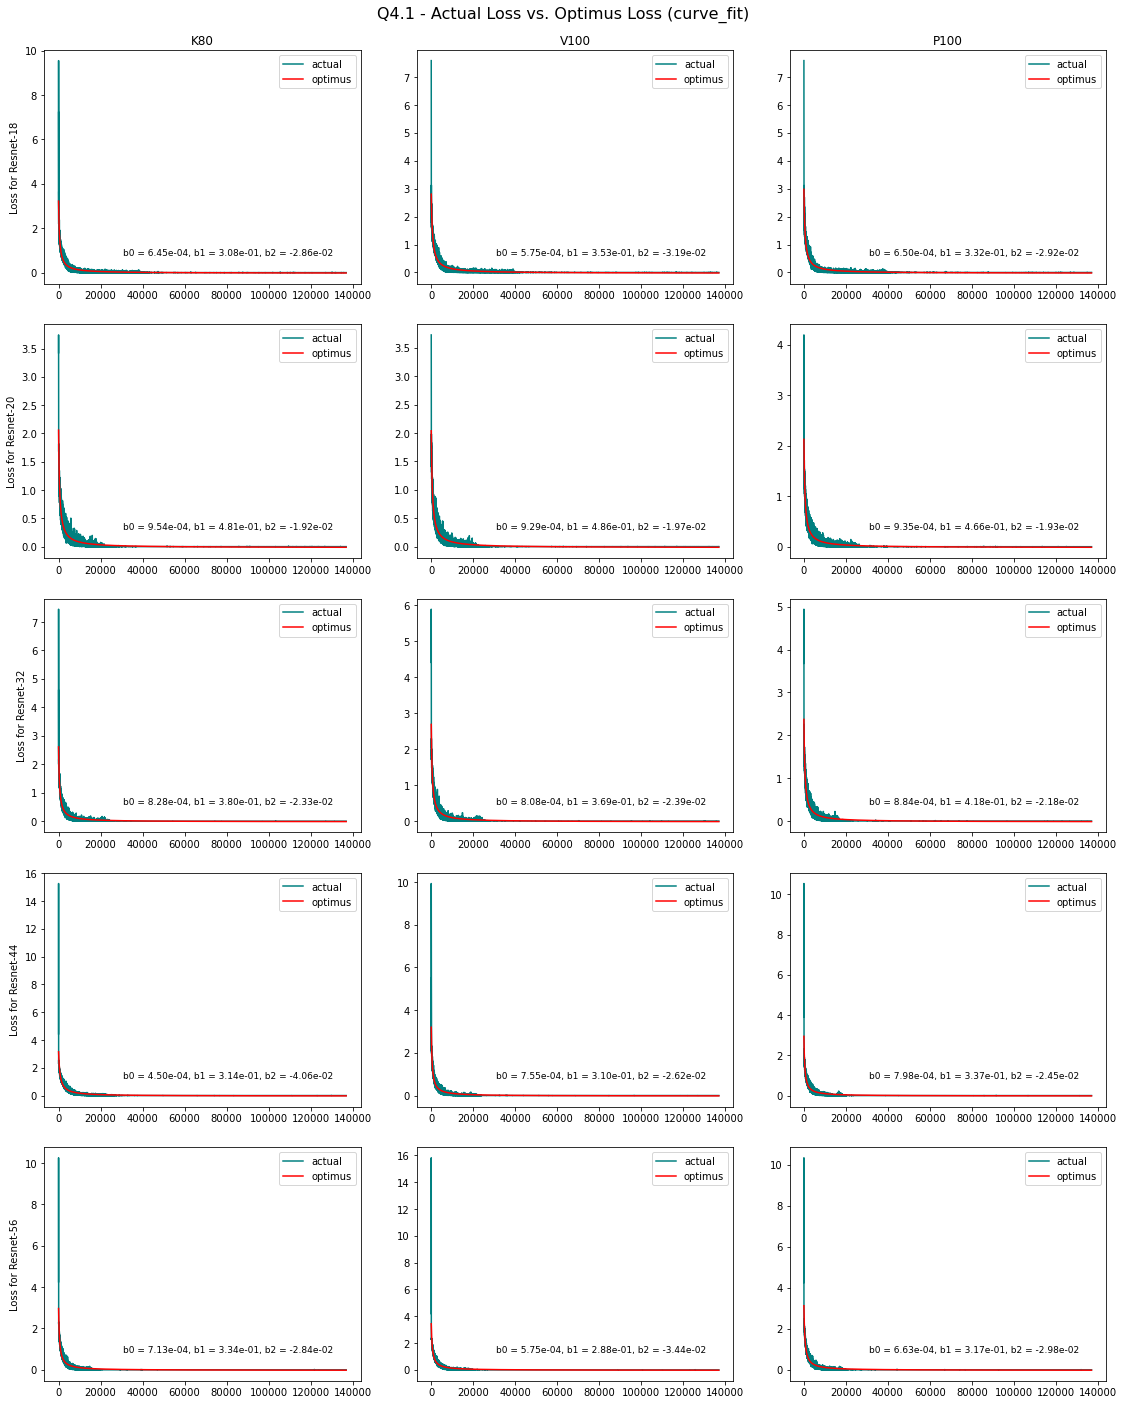

In [134]:
# define figure for plotting predicted loss
title = 'Q4.1 - Actual Loss vs. Optimus Loss (curve_fit)'
fig = plt.figure(figsize=(16,20))
fig.suptitle(title, fontsize=16)

layers = sorted(layers)
for i,layer in enumerate(layers):
    for j,gpu in enumerate(gpus):

        plot_df = train_df.loc[(train_df['hardware'] == gpu) & 
                             (train_df['resnet_layers'] == layer)]
        ##
        ax1 = fig.add_subplot(len(layers), len(gpus), (i*len(gpus) + j) + 1)
        # assign labels/titles strategically
        if j == 0:
            ax1.set_ylabel('Loss for Resnet-{}'.format(layer))
        if i == 0:
            ax1.set_title('{}'.format(gpu))
        if i == len(layers):
            ax1.set_xlabel('Step')
        # plot real loss and predicted loss
        ax1.plot(plot_df['training_step'], plot_df['training_step_loss'], color='teal',label='actual')
        ax1.plot(plot_df['training_step'], plot_df['optimus_loss'], color='red',label='optimus')
        ax1.legend()
        # display betas
        b = betas[gpu][layer]
        b_str = 'b0 = {:0.2e}, b1 = {:0.2e}, b2 = {:0.2e}'.format(b[0],b[1],b[2])
        ax1.text(0.25,0.15, b_str, transform=ax1.transAxes, fontsize=9,
                verticalalignment='top')

# configure ticks/labels/layout
plt.tight_layout(pad=2.0)
plt.show()

***
### 4.2 Predict training loss curve {-}
__From the regresssion model in 4.1, predict the training loss curve for Resnet-50. To verify how good is this prediction, train Resnet-50 on a K80, P100, and V100 for target accuracy of 92% and compare the predicted loss curve with the real measurements.__

In [148]:
# for regression, we must encode the categorical data. Let's one-hot encode
ohe_train_df = pd.get_dummies(train_df, columns=['hardware'], prefix='gpu')

# all models will share these inputs
X = ohe_train_df[['gpu_K80','gpu_P100','gpu_V100','resnet_layers']]
# these are the target outputs
beta_cols = ['beta_0','beta_1','beta_2']
# structure for storing predictions
gpu_configs = {'K80': {'config':[1,0,0],'betas':np.zeros(3)}, 
               'P100': {'config':[0,1,0], 'betas':np.zeros(3)},
               'V100': {'config':[0,0,1], 'betas':np.zeros(3)}}
# resnet layer we are interested in
pred_layer = 50
# prepare a new dataframe for 'pred_layer', based on training data
pred_df = train_df[train_df['resnet_layers']==18].copy()
pred_df = pred_df[['hardware','epoch','training_step']].reset_index(drop=True)
pred_df['resnet_layers'] = pred_layer
# add some new columns for storing predictions
pred_df['beta_0_pred'] = np.nan
pred_df['beta_1_pred'] = np.nan
pred_df['beta_2_pred'] = np.nan
pred_df['loss_pred'] = np.nan 
# loop through each gpu and make predictions
for gpu in gpu_configs:
    g = gpu_configs[gpu]
    # regression model for each beta
    b_model = linear_model.LinearRegression()
    b_model.fit(X, ohe_train_df[beta_cols])  
    # predict betas based on target Resnet layer
    g['betas'] = b_model.predict([g['config'] + [pred_layer]])
    b_pred = b_model.predict([g['config'] + [pred_layer]])[0]
    
    # store the predicted betas in dataframe
    pred_df.loc[pred_df['hardware'] == gpu,'beta_0_pred'] = b_pred[0]
    pred_df.loc[pred_df['hardware'] == gpu,'beta_1_pred'] = b_pred[1]
    pred_df.loc[pred_df['hardware'] == gpu,'beta_2_pred'] = b_pred[2]

    # get the target indices
    tmp_df = pred_df.loc[pred_df['hardware']==gpu]
    idxs = list(tmp_df.index.values)
    # grab the step (k)
    k = tmp_df['training_step'].values
    y = np.empty(len(k))        
    # predict the loss from optimus and store it in dataframe
    for i,idx in enumerate(idxs):
        y[i] = optimus(k[i],b_pred[0],b_pred[1],b_pred[2])
    pred_df.loc[pred_df['hardware'] == gpu,'loss_pred'] = y
    
    
# show the betas for Resnet-50, for each GPU 
disp_cols = ['hardware','resnet_layers','beta_0_pred',
             'beta_1_pred','beta_2_pred']
pred_df[disp_cols].groupby('hardware').first()

,resnet_layers,beta_0_pred,beta_1_pred,beta_2_pred
hardware,,,,
K80,50,0.000659,0.322218,-0.030912
P100,50,0.000727,0.332941,-0.027800
V100,50,0.000670,0.319989,-0.030109


#### Now we will validate our estimate obtained from the regression model by training a Resnet50 model on the CIFAR10 dataset using the exact same framework and hyperparameters before. This will be completed on the 3 GPUS (K80, P100, & V100) 

In [ ]:
# NOTE: the same framework from 4.1 is used, so the functions, dataset, dataloaders, etc., need to be initialized above.
prob_name = 'prob4_2'
save_epochs = 10
history = {}

# for checkpoints (save/load dir)
start_epoch = 0
save_dir = os.path.join('checkpoints',prob_name)
if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
# model_ft, history = load_checkpoint(model, save_dir, start_epoch) # uncomment to load model

# Fetch PyTorch model
model = models.resnet50()
# Set up criterion
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# Decay LR by a factor of 0.1 every 100 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# Send model to device
model = model.to(device)
# Train
num_epochs = 350
resnet_layers = 50
target_acc = 0.92
hardware = get_gpu_name(verbose=1)
model, results_df = train_model(model, resnet_layers, hardware, dataloaders,
                                criterion, optimizer, exp_lr_scheduler, num_epochs,
                                save_epochs=save_epochs, save_dir=save_dir,
                                status_epochs=np.ceil(num_epochs/10),train_acc=target_acc)


# save the data for others to use
results_file = 'resnet50_{}.csv'.format(hardware)
df_path = os.path.join(save_dir,results_file)
results_df.to_csv(df_path,columns=results_df.columns)

_Note: this is the output from the actual training_   
```
GPU: V100

Epoch 0/349
----------
train Loss: 4.6 Acc: 0.1279
val Loss: 2.2781 Acc: 0.1417
----------------------------------|34
Epoch 35/349
----------
train Loss: 0.2056 Acc: 0.9263
val Loss: 5.6081 Acc: 0.5909
Training complete in 11.0m 45.89620280265808s
Best val Acc: 0.5983
```

_Note: this is the output from the actual training_   
```
GPU: P100

Epoch 0/349
----------
train Loss: 4.6623 Acc: 0.1674
val Loss: 2.4195 Acc: 0.2177
---------------------------|27
Epoch 28/349
----------
train Loss: 0.2172 Acc: 0.9227
val Loss: 2.4185 Acc: 0.6269
Training complete in 14.0m 18.385379791259766s
Best val Acc: 0.6269
```

_Note: this is the output from the actual training_   
```
GPU: K80

Epoch 0/349
----------
train Loss: 4.3678 Acc: 0.1331
val Loss: 2.1291 Acc: 0.1891
----------------------------------|34
Epoch 35/349
----------
train Loss: 0.2296 Acc: 0.9184
val Loss: 1.7887 Acc: 0.6465

Epoch 36/349
----------
train Loss: 0.2069 Acc: 0.9269
val Loss: 1.9267 Acc: 0.6388
Training complete in 111.0m 4.5717737674713135s
Best val Acc: 0.6601
```

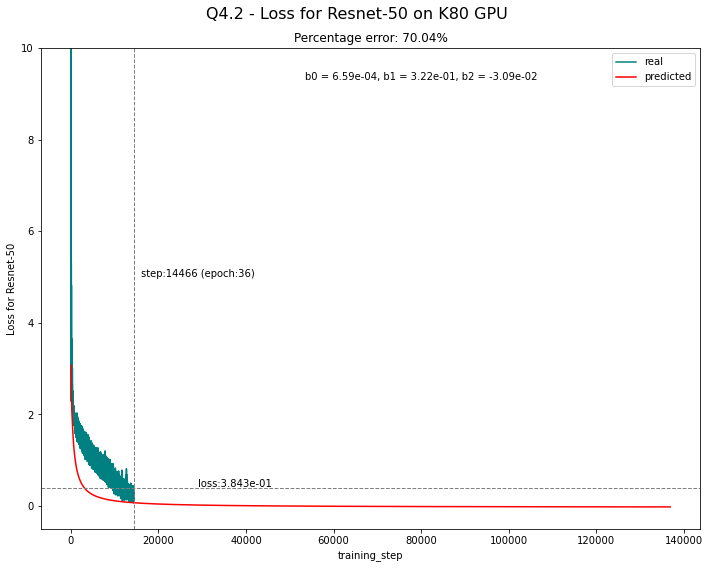

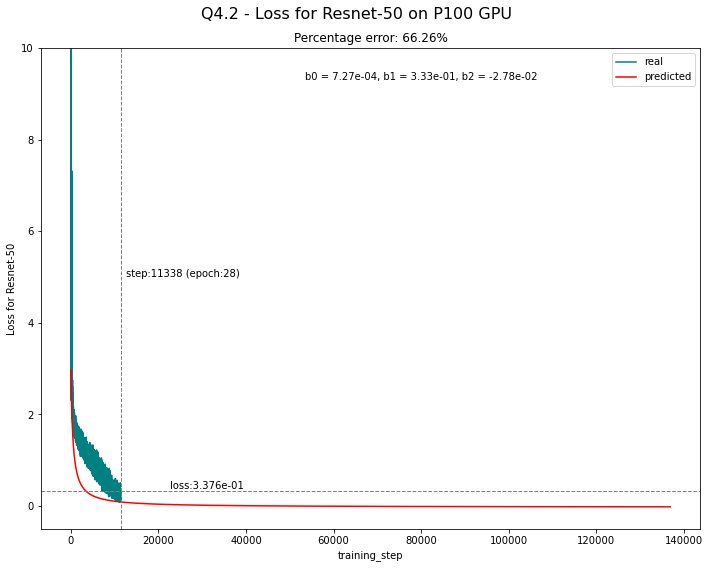

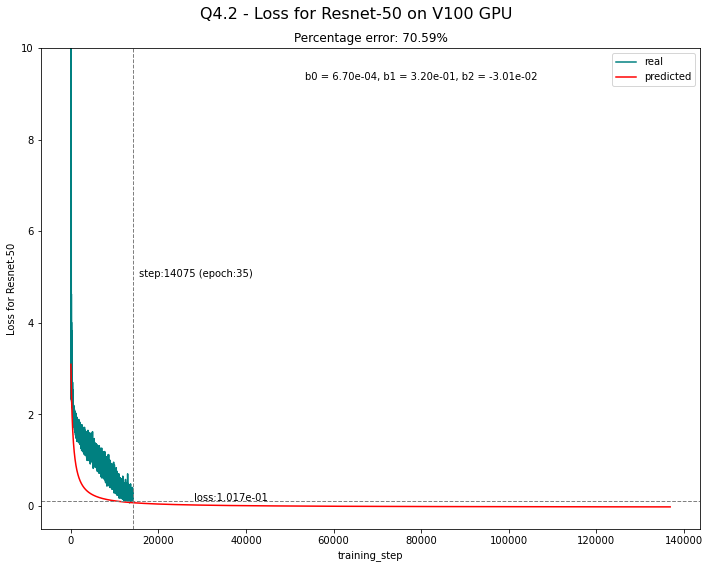

In [211]:
# Ref: https://stackoverflow.com/questions/57002948/how-to-calculate- ...
#       mean-absolute-percentage-error-for-regression-probem-in-python
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# plot the real training loss compared to the predicted for each GPU
for gpu in ['K80','P100','V100']:
    # calculate per epoch loss
    predicted = pred_df[pred_df['hardware'] == gpu]#.groupby('epoch').mean()
    actual = test_df[test_df['hardware'] == gpu]#.groupby('epoch').mean()
    # get the early stopping step (i.e., 92% accuracy step/epoch)
    stop_step = actual.training_step.values[-1]
    stop_epoch = actual.epoch.values[-1]
    stop_loss = actual.training_step_loss.values[-1]
    step_str = 'step:{} (epoch:{})'.format(stop_step,stop_epoch)
    loss_str = 'loss:{:0.3e}'.format(stop_loss)
    # calculate percentage error (for display)
    y_true = actual['training_step_loss'].values
    y_pred = predicted['loss_pred'].values[0:len(y_true)]
    y_err = mean_absolute_percentage_error(y_true, y_pred)
#     print('Mean Absolute Percentage Error (MAPE): {:0.3f}%'.format(y_err))
    # grab the beta values (for display)
    b0 = predicted['beta_0_pred'].values[0]
    b1 = predicted['beta_1_pred'].values[0]
    b2 = predicted['beta_2_pred'].values[0]    
    b_str = 'b0 = {:0.2e}, b1 = {:0.2e}, b2 = {:0.2e}'.format(b0,b1,b2)
    # define figure/axis
    title = 'Q4.2 - Loss for Resnet-{} on {} GPU'.format(50,gpu)
    fig = plt.figure(figsize=(10,8))
    fig.suptitle(title, fontsize=16)
    ax1 = fig.add_subplot(1, 1, 1)
    # assign labels/titles strategically
    ax1.set_title('Percentage error: {:0.2f}%'.format(y_err))
    ax1.set_ylabel('Loss for Resnet-{}'.format(50))
    ax1.set_xlabel('Step')
    ax1.set_ylim(-0.5,10)
    # plot real loss and predicted loss
    actual.plot(x='training_step',y='training_step_loss',
                color='teal',label='real',ax=ax1)
    predicted.plot(x='training_step',y='loss_pred',
                   color='red',label='predicted',ax=ax1)
    # add some text, etc.
    ax1.text(0.4,0.95, b_str, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top')
    ax1.text(x=stop_step+(stop_step*0.1), y=5, s=step_str, fontsize=10)    
    ax1.axvline(x=stop_step,color='gray',linestyle='--',linewidth=1)
    ax1.text(x=stop_step*2, y=stop_loss+stop_loss*0.1, s=loss_str, fontsize=10)    
    ax1.axhline(y=stop_loss,color='gray',linestyle='--',linewidth=1)
    ax1.legend()
    
    # draw the plots
    plt.tight_layout()
    plt.show()

__Answer:__ As shown in the plots above, the predicted loss curve is fairly close the the actual loss curve (following the general shape); however, the percentage error is quite high indicating that it is not perfect (likely due to the fact that we use linear regression to predict a non-linear function). It is possible that if we were to run for for 350 epochs the percentage error would be better given that we would have more samples to compare.

***
### 4.3 Predict time to reach 92% accuracy {-}
Using the predicted number of epochs for Resnet-50 along with the resource-speed model (use Equation (4) in Peng et al. along with its coefficients from the paper) obtain the time to accuracy of Resnet-50 (to reach 92% accuracy) in two different setting (with 2 and 4 parameter servers respectively) as a function of the number of workers.    
$$
f(p,w) = \big( \theta_{0} \cdot \frac{M}{w} +\theta_{1} + \theta_{2} \cdot \frac{w}{p} + \theta_{3} \cdot w + \theta_{4} \cdot p \big)^{-1}
$$
where $p$ is the number of parameter servers, $w$ is the number of workers, $M$ is the batch size, and $\theta$'s are the coefficients (we will use the ones from the paper)

_Reference:_   
[1] Peng et al. Optimus: An Efficient Dynamic Resource Scheduler for Deep Learning Clusters Available at https://i.cs.hku.hk/ cwu/papers/yhpeng-eurosys18.pdf

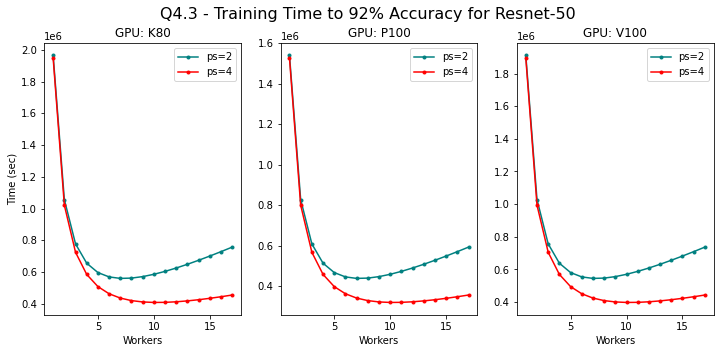

In [215]:
# define speed function
def sync_fpw(t,M,w,p):
    return 1/(t[0]*(M/w)+t[1]+t[2]*(w/p)+t[3]*w+t[4]*p)

thetas = np.array([1.02,2.78,4.92,0.0,0.02])
workers = np.arange(1,18,1)
servers = np.array([2,4])
M = 128 #batch_size

# define figure/axis
title = 'Q4.3 - Training Time to 92% Accuracy for Resnet-50'
fig = plt.figure(figsize=(12,5))
fig.suptitle(title, fontsize=16)

for i,gpu in enumerate(['K80','P100','V100']):
    actual = test_df[test_df['hardware'] == gpu]#.groupby('epoch').mean()
#     predicted = pred_df[pred_df['hardware'] == gpu]#.groupby('epoch').mean()

    # get the early stopping step (i.e., 92% accuracy step/epoch)
    stop_step = actual.training_step.values[-1]
#     stop_step = predicted.training_step.values[-1]
    res = {2:[],4:[]}
    for p in servers:
        for w in workers:
            res[p].append(sync_fpw(thetas,M,w,p))

    ps2 = ((stop_step)/res[2])
    ps4 = ((stop_step)/res[4])
    # steps/s -> s ==> (# steps to 92%) / steps/s
    
    ax1 = fig.add_subplot(1, 3, i+1)
    # assign labels/titles strategically
    ax1.set_title('GPU: {}'.format(gpu))
    if(i==0):
        ax1.set_ylabel('Time (sec)')
    ax1.set_xlabel('Workers')
    # plot real loss and predicted loss
    ax1.plot(workers,ps2,'.-',color='teal',label='ps=2')
    ax1.plot(workers,ps4,'.-', color='red',label='ps=4')
    ax1.legend()

plt.show()



**_Note:_** _it is not clear to me why the y-axis scale is so large; however, the shape of the curve makes sense based on the paper. For synchrnous PS configurations, the time to reach 92% accuracy should drop to a minimum as the number of workers increase; however, there is a point where having more workers does not improve the performace due to the communication overhead. This is illustrated in the plots above._

In [ ]:
# os.system('sudo shutdown now')